In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset

from utils import mnist, plot_graphs, plot_mnist # functions for loading and plotting MNIST
import numpy as np

import matplotlib.pyplot as plt
import h5py


%matplotlib inline

In [2]:
batch_size=256
rho = 0.05
beta=2#5
NUM_EPOCHS=20
which_GPU = '0'
device = torch.device("cuda:"+which_GPU)


<font face="微软雅黑" size=5 color=#A52A2A > Data Reader

In [3]:
for i in range(10):
    f = h5py.File('../../data/'+str(i)+'.h5', 'r')
    if i==0:
        X = np.asarray(f['XSE'])
        Y = np.asarray(f['YSE'])
    if i!=0:
        X= np.vstack((X,np.asarray(f['XSE'])))
        Y= np.vstack((Y,np.asarray(f['YSE'])))

In [4]:
xTrain_data,xTest_data=np.split(X,[500000],axis=0)
print(xTrain_data.shape)
print(xTest_data.shape)
xTrain_data=xTrain_data.astype('float32')
xTest_data=xTest_data.astype('float32')
x_train=(xTrain_data-np.min(xTrain_data))/(np.max(xTrain_data)-np.min(xTrain_data))
x_train=np.reshape(x_train,(500000,1,2000))
x_test=(xTest_data-np.min(xTest_data))/(np.max(xTest_data)-np.min(xTest_data))
x_test=np.reshape(x_test,(40000,1,2000))

(500000, 2000)
(40000, 2000)


In [5]:
yTrain_data,yTest_data=np.split(Y,[500000],axis=0)
print(yTrain_data.shape)
print(yTest_data.shape)
yTrain_data=yTrain_data.astype('float32')
yTest_data=yTest_data.astype('float32')
y_train=(yTrain_data-np.min(yTrain_data))/(np.max(yTrain_data)-np.min(yTrain_data))
y_train=np.reshape(y_train,(500000,1,300))
y_test=(yTest_data-np.min(yTest_data))/(np.max(yTest_data)-np.min(yTest_data))
y_test=np.reshape(y_test,(40000,1,300))

(500000, 300)
(40000, 300)


In [6]:
class SEDataset(Dataset):
    def __init__(self,X,Y):
        self.data=[]
        for x,y in zip(X,Y):
            self.data.append([x, y])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x=self.data[idx][0]
        y = self.data[idx][1]
        return x, y
    

In [7]:
trainset=SEDataset(x_train,y_train)
testset=SEDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,num_workers=0)
test_loader= torch.utils.data.DataLoader(testset,batch_size=batch_size)

In [8]:
# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #self.fc1 = nn.Linear(2000, 128)
        self.conv1=nn.Conv1d(in_channels=4,out_channels=16,kernel_size=5,stride= 2)
        self.conv2=nn.Conv1d(in_channels=16,out_channels=32,kernel_size=3,stride= 2)
        #self.conv3=nn.Conv1d(in_channels=32,out_channels=64,kernel_size=3,stride= 2)
        #self.fc2 = nn.Linear(2000, 1024)
        #self.fc3 = nn.Linear(1024, 256)
        #self.fc4 = nn.Linear(256, 56)
    
    def forward(self, x):
        x = x.reshape(-1,4,500)
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        #x = F.relu(self.conv3(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #self.fc4 = nn.Linear(128, 2000)
        #self.conv1=nn.Conv1d(in_channels=64,out_channels=32,kernel_size=3,stride= 1,padding=1)
        self.conv2=nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3,stride= 1,padding=1)
        self.conv3=nn.Conv1d(in_channels=16,out_channels=4,kernel_size=5,stride= 1,padding=1)
        
        self.fc = nn.Linear(1952,2000)
        #self.fc3 = nn.Linear(256, 1024)
        #self.fc2 = nn.Linear(1024, 2000)
        #self.fc1 = nn.Linear(2000, 2000)
    
    def forward(self, x):
        #x = self.fc4(x)
        #x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x= F.interpolate(x, scale_factor=2 )
        x = F.relu(self.conv3(x))
        x= F.interpolate(x, scale_factor=2 )
        x = x.reshape(-1,1,1952)
        x=self.fc(x)
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc1(x)
        return x
    
class Regression(nn.Module):
    def __init__(self):
        super(Regression,self).__init__()
        self.conv1=nn.Conv1d(in_channels=32,out_channels=16,kernel_size=3,stride= 1,padding=1)
        self.conv2=nn.Conv1d(in_channels=16,out_channels=4,kernel_size=3,stride= 1,padding=1)
        self.fc1=nn.Linear(492,300)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x=x.reshape(-1,1,492)
        x=self.fc1(x)
        return x

In [9]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, loss_fn=F.mse_loss, lr=1e-4, l2=0.):#3e-4
        super(Net, self).__init__()
        self.E = Encoder()
        self.D = Decoder()
        self.R = Regression()
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        h = self.E(x)
        self.data_rho = h.mean(0) # calculates rho from encoder activations
        out = self.D(h)
        return out
    def regression(self,x):
        h = self.E(x)
        out =self.R(h)
        return out
        
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):        
        dkl = - rho * torch.log(self.data_rho) - (1-rho)*torch.log(1-self.data_rho) # calculates KL divergence
        
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [10]:
# Making AEs with 16, 64 and 256 neurons in latent layer

model =Net().cuda(device)

In [11]:
# Train function

def train(epoch, model,beta):
    loss_total=0
    train_size = len(train_loader)
    for batch_idx, (x,_) in enumerate(train_loader):
        model.optim.zero_grad()
        inputs = x.to(device)#.clone().detach()
        inputs = Variable(inputs, requires_grad=True)
        output = model(inputs)
        if beta!=0:
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, inputs) + beta*rho_loss
        else:
            loss = model.loss(output, inputs)
        loss.backward()
        model.optim.step()
        loss_total+=loss.item()
        
    return loss_total/float(train_size)

In [12]:
def train_R(epoch, model,beta):
    loss_total=0
    train_size = len(train_loader)
    for batch_idx, (x,y) in enumerate(train_loader):
        model.optim.zero_grad()
        inputs = x.to(device)#.clone().detach()
        labels = y.to(device)
        inputs = Variable(inputs, requires_grad=True)
        labels = Variable(labels)
        output = model.regression(inputs)
        loss = model.loss(output, labels)
        loss.backward()
        model.optim.step()
        loss_total+=loss.item()
        
    return loss_total/float(train_size)

In [13]:
def test(model):
    loss_total=0
    test_size = len(test_loader)
    for batch_idx,(x,_) in enumerate(test_loader):
        inputs = x.to(device)
        inputs = Variable(inputs, requires_grad=False)
        output = model(inputs)
        loss = model.loss(output, inputs)
        loss_total+=loss.item()

    return loss_total/float(test_size)

In [14]:
def test_R(model):
    loss_total=0
    test_size = len(test_loader)
    for batch_idx,(x,y) in enumerate(test_loader):
        inputs = x.to(device)
        labels = y.to(device)
        inputs = Variable(inputs, requires_grad=False)
        labels = Variable(labels)
        output = model.regression(inputs)
        loss = model.loss(output, labels)
        loss_total+=loss.item()
    return loss_total/float(test_size)

In [15]:
def plot_auto(net, testloader, indices):
    for x,y in testloader:
        x = x.to(device)
        y = y.to(device)
        outputs = net.regression(x).cpu().detach().numpy()
        break
    output1=outputs.reshape((256, 300))
    y=y.reshape((256, 300))
    print(np.mean((output1- y.cpu().detach().numpy())** 2))
    plt.plot(y[indices].cpu().detach().numpy(), label ='GT')
    print(y[indices].cpu().detach().numpy().shape)
    plt.plot(output1[indices], label = 'predicted')
    plt.title('XSE predict YSE')
    plt.legend()

In [16]:
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    train_loss=train(epoch, model,beta)

    model.eval()
    test_loss=test(model)
    print('SAE Epoch {} of {}, Train Loss: {:.3f}, Val Loss: {:.3f}'.format(epoch, NUM_EPOCHS, train_loss, test_loss ))
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    train_loss=train_R(epoch, model,beta)
    model.eval()
    test_loss=test_R(model)
    print('R Epoch {} of {}, Train Loss: {:.3f}, Val Loss: {:.3f}'.format(epoch, NUM_EPOCHS, train_loss, test_loss ))

SAE Epoch 1 of 20, Train Loss: 0.710, Val Loss: 0.001
SAE Epoch 2 of 20, Train Loss: 0.399, Val Loss: 0.001
SAE Epoch 3 of 20, Train Loss: 0.399, Val Loss: 0.001
SAE Epoch 4 of 20, Train Loss: 0.399, Val Loss: 0.001
SAE Epoch 5 of 20, Train Loss: 0.398, Val Loss: 0.001
SAE Epoch 6 of 20, Train Loss: 0.398, Val Loss: 0.001
SAE Epoch 7 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 8 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 9 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 10 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 11 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 12 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 13 of 20, Train Loss: 0.397, Val Loss: 0.001
SAE Epoch 14 of 20, Train Loss: 0.397, Val Loss: 0.002
SAE Epoch 15 of 20, Train Loss: 0.397, Val Loss: 0.002
SAE Epoch 16 of 20, Train Loss: 0.397, Val Loss: 0.002
SAE Epoch 17 of 20, Train Loss: 0.397, Val Loss: 0.002
SAE Epoch 18 of 20, Train Loss: 0.397, Val Loss: 0.002
SAE Epoch 19 of 20,

0.0044297446
(300,)


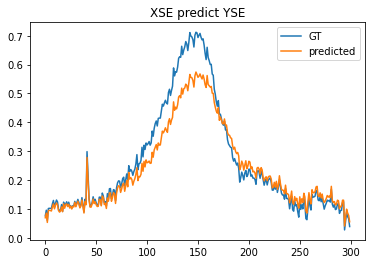

In [24]:
plot_auto(model,test_loader, 200)

0.004669798
(300,)


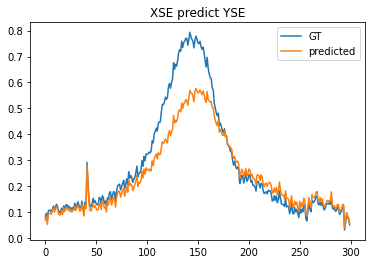

In [24]:
plot_auto(model,train_loader, 10)